In [1]:
import sys
sys.path.append('../src')

In [89]:
import csv
import yaml
import tqdm
import math
import pickle
import numpy as np
import pandas as pd
import itertools
import operator
from operator import concat, itemgetter
from pickle_wrapper import unpickle, pickle_it
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
from pathlib import Path
from collections import defaultdict
from functools import reduce
from operator import concat, itemgetter
import ast



from pickle_wrapper import unpickle, pickle_it
from mcmc_norm_learning.algorithm_1_v4 import to_tuple
from mcmc_norm_learning.algorithm_1_v4 import create_data
from mcmc_norm_learning.rules_4 import get_prob, get_log_prob
from mcmc_norm_learning.environment import position,plot_env
from mcmc_norm_learning.robot_task_new import task, robot, plot_task
from mcmc_norm_learning.algorithm_1_v4 import algorithm_1, over_dispersed_starting_points
from mcmc_norm_learning.mcmc_convergence import prepare_sequences, calculate_R
from mcmc_norm_learning.rules_4 import q_dict, rule_dict, get_log_prob
from algorithm_2_utilities import Likelihood
from mcmc_norm_learning.mcmc_performance import performance
from collections import Counter

In [85]:
with open("../params_nc.yaml", 'r') as fd:
    params = yaml.safe_load(fd)

### Step 1a: Default Environment and params

In [4]:
##Get default env
env = unpickle('../data/env.pickle')

In [86]:
##Get default task
true_norm_exp = params['true_norm']['exp']
num_observations = params['num_observations']
obs_data_set = params['obs_data_set']

w_nc=params["w_nc"]
n = params['n']
m = params['m']
rf = params['rf']
rhat_step_size = params['rhat_step_size']
top_n = params["top_norms_n"]


colour_specific = params['colour_specific']
shape_specific = params['shape_specific']
target_area_parts = params['target_area'].replace(' ','').split(';')
target_area_part0 = position(*map(float, target_area_parts[0].split(',')))
target_area_part1 = position(*map(float, target_area_parts[1].split(',')))
target_area = (target_area_part0, target_area_part1)
print(target_area_part0.coordinates())
print(target_area_part1.coordinates())
the_task = task(colour_specific, shape_specific,target_area)

(-0.8, 0.7)
(0.25, 0.99)


(0.0, 1.0, 0.0, 1.0)

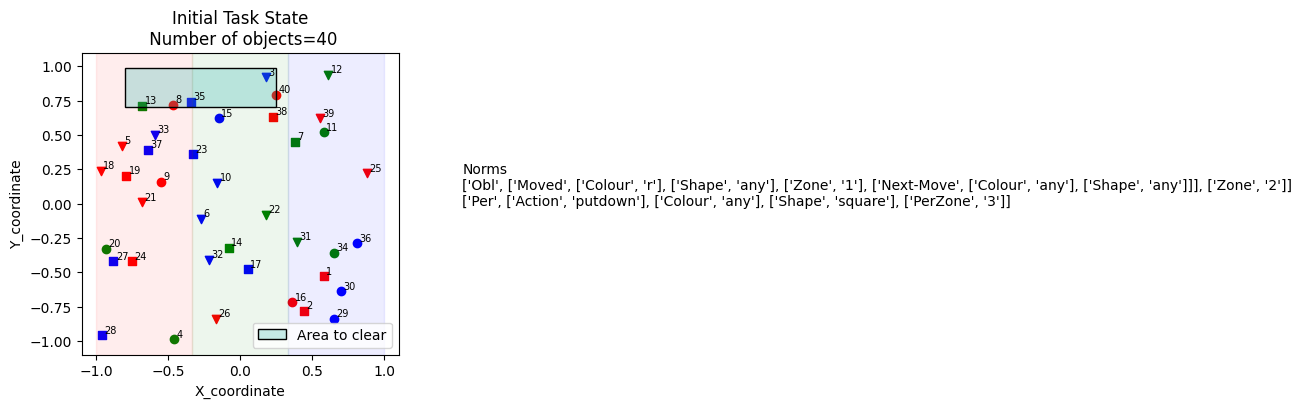

In [6]:
fig,axs=plt.subplots(1,2,figsize=(9,4),dpi=100);
plot_task(env,axs[0],"Initial Task State",the_task,True)
axs[1].text(0,0.5,"\n".join([str(x) for x in true_norm_exp]),wrap=True)
axs[1].axis("off")

### Step 2: Non Compliant Obs

In [7]:
obs = nc_obs= create_data(true_norm_exp,env,name=None,task=the_task,random_task=False,
                               num_actionable=np.nan,num_repeat=num_observations,w_nc=w_nc,verbose=False)

Repetition of Task: 100%|██████████| 50/50 [00:00<00:00, 659.73it/s]


In [8]:
true_norm_prior = get_prob("NORMS",true_norm_exp) 
true_norm_log_prior = get_log_prob("NORMS",true_norm_exp) 

In [9]:
if not Path('../data_nc/observations_ad_0.1.pickle').exists():
    pickle_it(obs, '../data_nc/observations_ad_0.1.pickle')

### Step 3: MCMC chains

In [10]:
%%capture
num_chains = math.ceil(m/2)
starts, info = over_dispersed_starting_points(num_chains,obs,env,\
                                              the_task,time_threshold=math.inf,w_normative=(1-w_nc))

In [11]:
with open('../metrics/starts_info_nc.txt', 'w') as chain_info:
    chain_info.write(info)

In [12]:
@dask.delayed
def delayed_alg1(obs,env,the_task,q_dict,rule_dict,start,rf,max_iters,w_nc):
    exp_seq,log_likelihoods = algorithm_1(obs,env,the_task,q_dict,rule_dict,
                                        "dummy value",start = start,relevance_factor=rf,\
                                          max_iterations=max_iters,w_normative=1-w_nc,verbose=False)
    log_posteriors = [None]*len(exp_seq)
    for i in range(len(exp_seq)):
        exp = exp_seq[i]
        ll = log_likelihoods[i]
        log_prior = get_log_prob("NORMS",exp) # Note: this imports the rules dict from rules_4.py
        log_posteriors[i] = log_prior + ll
    return {'chain': exp_seq, 'log_posteriors': log_posteriors}

In [13]:
%%time
%%capture
chains_and_log_posteriors=[]
for i in tqdm.tqdm(range(num_chains),desc="Loop for Individual Chains"):
    chains_and_log_posteriors.append(
        delayed_alg1(obs,env,the_task,q_dict,rule_dict,starts[i],rf,4*n,w_nc).compute())

CPU times: user 5min 19s, sys: 1.16 s, total: 5min 20s
Wall time: 5min 22s


In [14]:
pickle_it(chains_and_log_posteriors, '../data_nc/chains_and_log_posteriors.pickle')

### Step 4: Pass to analyse chains

In [16]:
with open('../metrics/chain_posteriors_nc.csv', 'w', newline='') as csvfile, \
     open('../metrics/chain_info.txt', 'w') as chain_info:
    chain_info.write(f'Number of chains: {len(chains_and_log_posteriors)}\n')
    chain_info.write(f'Length of each chain: {len(chains_and_log_posteriors[0]["chain"])}\n')
    
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(('chain_number', 'chain_pos', 'expression', 'log_posterior'))
    exps_in_chains = [None]*len(chains_and_log_posteriors)
    for i,chain_data in enumerate(chains_and_log_posteriors): # Consider skipping first few entries
        chain = chain_data['chain']
        log_posteriors = chain_data['log_posteriors']
        exp_lp_pairs = list(zip(chain,log_posteriors))

        exps_in_chains[i] = set(map(to_tuple, chain))

        #print(sorted(log_posteriors, reverse=True))

        lps_to_exps = defaultdict(set)
        for exp,lp in exp_lp_pairs:
            lps_to_exps[lp].add(to_tuple(exp))

        num_exps_in_chain = len(exps_in_chains[i])

        print(lps_to_exps.keys())
        print('\n')

        chain_info.write(f'Num. expressions in chain {i}: {num_exps_in_chain}\n')
        decreasing_lps = sorted(lps_to_exps.keys(), reverse=True)
        chain_info.write("Expressions by decreasing log posterior\n")
        for lp in decreasing_lps:
            chain_info.write(f'lp = {lp} [{len(lps_to_exps[lp])} exps]:\n')
            for exp in lps_to_exps[lp]:
                chain_info.write(f'    {exp}\n')
            chain_info.write('\n')
        chain_info.write('\n')

        changed_exp_indices = [i for i in range(1,len(chain)) if chain[i] != chain[i-1]]
        print(f'Writing {len(exp_lp_pairs)} rows to CSV file\n')
        csv_writer.writerows(((i,j,chain_lp_pair[0],chain_lp_pair[1]) for j,chain_lp_pair in enumerate(exp_lp_pairs)))

    all_exps = set(itertools.chain(*exps_in_chains))
    chain_info.write(f'Total num. distinct exps across all chains (including warm-up): {len(all_exps)}\n')

    true_norm_exp = params['true_norm']['exp']
    true_norm_tuple = to_tuple(true_norm_exp)
    
    chain_info.write(f'True norm in some chain(s): {true_norm_tuple in all_exps}\n')

    num_chains_in_to_exps = defaultdict(set)
    for exp in all_exps:
        num_chains_in = operator.countOf(map(operator.contains, 
                                                exps_in_chains,
                                                (exp for _ in range(len(exps_in_chains)))
                                            ),
                                        True)
        num_chains_in_to_exps[num_chains_in].add(exp)
    for num in sorted(num_chains_in_to_exps.keys(), reverse=True):
        chain_info.write(f'Out of {len(exps_in_chains)} chains ...\n')
        chain_info.write(f'{len(num_chains_in_to_exps[num])} exps are in {num} chains.\n')
csvfile.close()
chain_info.close()

dict_keys([-18862.095952127733, -13741.494622661046, -13740.396010372377, -13742.593234949714, -13744.79045952705, -13733.346755531122, -13592.544771527248, -13591.44615923858, -13541.063800668202, -13542.16241295687, -13543.261025245538])


Writing 800 rows to CSV file

dict_keys([-13740.396010372377, -13741.494622661046, -13733.346755531122, -13739.820646227474, -13739.415181119366, -13752.768427620178, -13753.867039908846, -13751.66981533151, -13746.582218996278, -13747.680831284946, -13656.886202498481, -13604.306619350768, -13605.405231639435, -13603.2080070621, -13606.503843928103, -13602.210359029255, -13603.308971317923, -13604.407583606591])


Writing 800 rows to CSV file



In [21]:
result=pd.read_csv("../metrics/chain_posteriors_nc.csv")

In [62]:
log_post_no_norm=Likelihood(["Norms",["No-Norm"]],the_task,obs,env,w_normative=1-w_nc)
log_post_true_norm=Likelihood(true_norm_exp,the_task,obs,env,w_normative=1-w_nc)

print(log_post_no_norm,log_post_true_norm)

-13732.653608350562 -13201.800300297418


In [28]:
result.groupby("chain_number")[["log_posterior"]].agg(['min','max','mean','std'])

log_posterior                                        
                       min           max          mean         std
chain_number                                                      
0            -18862.095952 -13541.063801 -13560.823592  190.947880
1            -13753.867040 -13602.210359 -13648.032638   62.170889

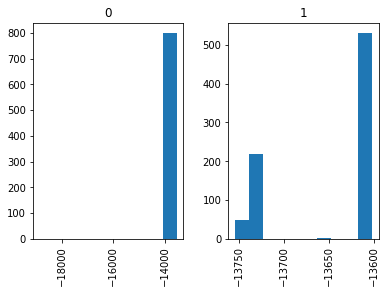

In [73]:
hist_plot=result['log_posterior'].hist(by=result['chain_number'],bins=10)
plt.savefig("../data_nc/nc_hist.jpg")

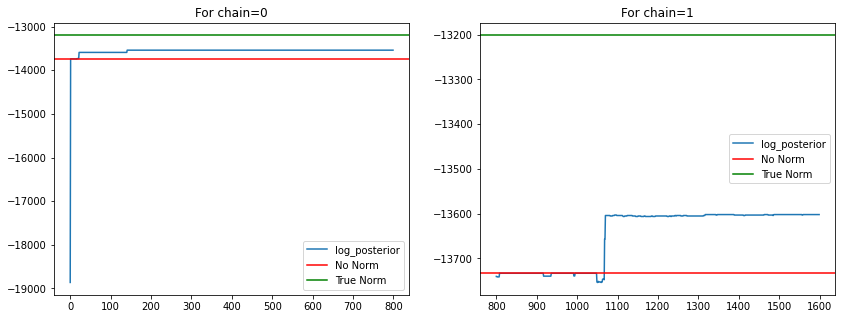

<Figure size 432x288 with 0 Axes>

In [74]:
grouped = result.groupby('chain_number')[["log_posterior"]]

ncols=2
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,5), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax)
    ax.axhline(y=log_post_no_norm,label="No Norm",c='r')
    ax.axhline(y=log_post_true_norm,label="True Norm",c='g')
    ax.title.set_text("For chain={}".format(key))
    ax.legend()
plt.show()
plt.savefig("../plots/nc_movement.jpg")

### Step 5: Convergence Tests

In [76]:
def conv_test(chains):
    convergence_result, split_data = calculate_R(chains, rhat_step_size)
    with open('../metrics/conv_test_nc.txt', 'w') as f:
        f.write(convergence_result.to_string())
    return reduce(concat, split_data)

In [79]:
chains = list(map(itemgetter('chain'), chains_and_log_posteriors))
posterior_sample = conv_test(prepare_sequences(chains, warmup=True))
pickle_it(posterior_sample, '../data_nc/posterior_nc.pickle')


Calculating Variance for 1st 50 iterations
Temp. check: seq length is 50
Time taken for job=0.1s

Calculating Variance for 1st 100 iterations
Temp. check: seq length is 100
Time taken for job=0.2s

Calculating Variance for 1st 199 iterations
Temp. check: seq length is 199
Time taken for job=0.5s



### Step 6: Extract Top Norms

In [82]:
learned_expressions=Counter(map(to_tuple, posterior_sample))

In [87]:
top_norms_with_freq = learned_expressions.most_common(top_n)
top_norms = list(map(operator.itemgetter(0), top_norms_with_freq))

In [90]:
exp_posterior_df = pd.read_csv('../metrics/chain_posteriors_nc.csv', usecols=['expression','log_posterior'])
exp_posterior_df = exp_posterior_df.drop_duplicates()
exp_posterior_df['post_rank'] = exp_posterior_df['log_posterior'].rank(method='dense',ascending=False)
exp_posterior_df.sort_values('post_rank', inplace=True)
exp_posterior_df['expression'] = exp_posterior_df['expression'].transform(ast.literal_eval)
exp_posterior_df['expression'] = exp_posterior_df['expression'].transform(to_tuple)

In [91]:
exp_posterior_df

,expression,log_posterior,post_rank
255,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13541.063801,1.0
219,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13541.063801,1.0
141,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13541.063801,1.0
258,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13542.162413,2.0
253,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13542.162413,2.0
...,...,...,...
1049,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13752.768428,24.0
1050,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13753.867040,25.0
1059,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13753.867040,25.0
1060,"(Norm, (Obl, (Moved, ('Colour', 'any'), ('Shap...",-13753.867040,25.0


In [92]:
def log_posterior(exp, exp_lp_df):
    return exp_lp_df.loc[exp_lp_df['expression'] == exp]['log_posterior'].iloc[0]

In [93]:
with open('../metrics/precision_recall_nc.txt', 'w') as f:
    f.write("Number of unique Norms in sequence={len(learned_expressions)}\n")
    f.write(f"Top {n} norms:\n")
    for expression,freq in top_norms_with_freq:
        f.write(f"Freq. {freq}, lp {log_posterior(expression, exp_posterior_df)}: ")
        f.write(f"{expression}\n")
    f.write("\n")

In [95]:
pr_result=performance(the_task,env,true_norm_exp,learned_expressions,
                        folder_name="temp",file_name="top_norm",
                        top_n=n,beta=1,repeat=100000,verbose=False)

Repetition of Task:   0%|          | 126/100000 [00:00<02:44, 608.65it/s]

True expression passed to performance(...): ['Norms', ['Obl', ['Moved', ['Colour', 'r'], ['Shape', 'any'], ['Zone', '1'], ['Next-Move', ['Colour', 'any'], ['Shape', 'any']]], ['Zone', '2']], ['Per', ['Action', 'putdown'], ['Colour', 'any'], ['Shape', 'square'], ['PerZone', '3']]]


Repetition of Task:  15%|█▍        | 14658/100000 [00:20<02:00, 707.65it/s]


KeyboardInterrupt: 

In [102]:
top_norms[3]

('Norms',
 ('Obl',
  ('Moved',
   ('Colour', 'g'),
   ('Shape', 'square'),
   ('Zone', '3'),
   ('Next-Move', ('Colour', 'any'), ('Shape', 'any'))),
  ('Zone', '1')),
 ('Per',
  ('Action', 'putdown'),
  ('Colour', 'r'),
  ('Shape', 'any'),
  ('PerZone', '2')))

In [97]:
true_norm_exp

['Norms',
 ['Obl',
  ['Moved',
   ['Colour', 'r'],
   ['Shape', 'any'],
   ['Zone', '1'],
   ['Next-Move', ['Colour', 'any'], ['Shape', 'any']]],
  ['Zone', '2']],
 ['Per',
  ['Action', 'putdown'],
  ['Colour', 'any'],
  ['Shape', 'square'],
  ['PerZone', '3']]]